In [426]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.constants import L_v, c_p,g,R, kappa
from isca_tools.utils.moist_physics import saturation_vapor_pressure, clausius_clapeyron_factor, sphum_sat, \
    sphum_from_dew, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx, get_temp_adiabat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
from geopy.distance import geodesic
from scipy.ndimage import distance_transform_edt
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%time
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 27.9 µs


In [3]:
def time_to_year(ds):
    ds = ds.assign_coords(year=ds['time'].dt.year)  # Add a 'year' coordinate
    ds = ds.swap_dims({'time': 'year'})             # Replace 'time' as dimension with 'year'
    ds = ds.drop_vars('time')                       # Optionally remove 'time' variable
    return ds

In [4]:
exp_path = ['./pre_industrial/output.nd2', './co2_2x/output.nd2']
exp_labels = ['Pre industrial', '$CO_2 \\times 2$']
n_exp = len(exp_path)
ds = []
for i in range(n_exp):
    ds.append(xr.load_dataset(exp_path[i]).isel(quant=0, plev=0).load())

In [5]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

### Height
#### My Theory
In my theory, the geopotential height difference between free troposphere and surface is expressed in terms of surface temperature, $T_s$, free tropospheric temperature, $T_{500}$ and surface pressure $p_s$.

In my work up until now, I have been considering $\sigma$ levels so $p_s/p_{FT}$ has been the same everywhere. Or equally, I have been considering the same location over different percentiles, where again $p_s/p_{FT}$ does not change much.

But here, I am considering the same percentile at different spatial locations, thus the variation of $p_s$ is vital and cannot be neglected.

#### Zhang 2023
In the Zhang 2023 formulation, $z_{500}$ is expressed in terms of $T_{FT}$ only, and then $z_s$ is required as well to link $h_{FT}^*$ to $h_s$. Below we see that this approximation is less good compared to my equation, but it is still very reasonable.

This has the advantage of being in terms of $z_s$ rather than $p_s$; and that $z_s$ does not vary across the percentile distribution or with time, whereas $p_s$ does. So for considering spatial variation, it makes sense to do this formulation.

I think it will just end up with a $\Delta z_s$ term. This probably makes sense, as the larger $z_s$, the closer $p_s$ is to 500hPa, and so the closer $T_s$ will be to $T_{500}$. In the Tibetan Plateau, I think $p_s$ is actually lower than 500hPa.

In [6]:
# Mean 500-hPa values between 40N-65N over land during 1979-2021
z500_mean = 55.74162890625 * 1000   # 5 km x 9.81 would be 55 so the zhang value of 55 must be in units of km multiplied by g
t500_mean = 258.82523

def get_z_theory(temp_surf, temp_ft, p_surf, p_ft=500*100, taylor=True):
    # Returns z500 - z2m
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return R_mod/g * (temp_surf + temp_ft)
    else:
        return (temp_surf - temp_ft) * 2 * R_mod / g / np.log(temp_surf / temp_ft)

def get_z_theory_zhang(temp_ft, z2m=z2m):
    # Returns z500 - z2m
    return z500_mean/t500_mean * temp_ft / g - z2m

z_diff_plot = {'simulated': ds[0].Z3 - z2m,
               'zhang': get_z_theory_zhang(ds[0].T),
               'theory': get_z_theory(ds[0].TREFHT, ds[0].T, ds[0].PS)}

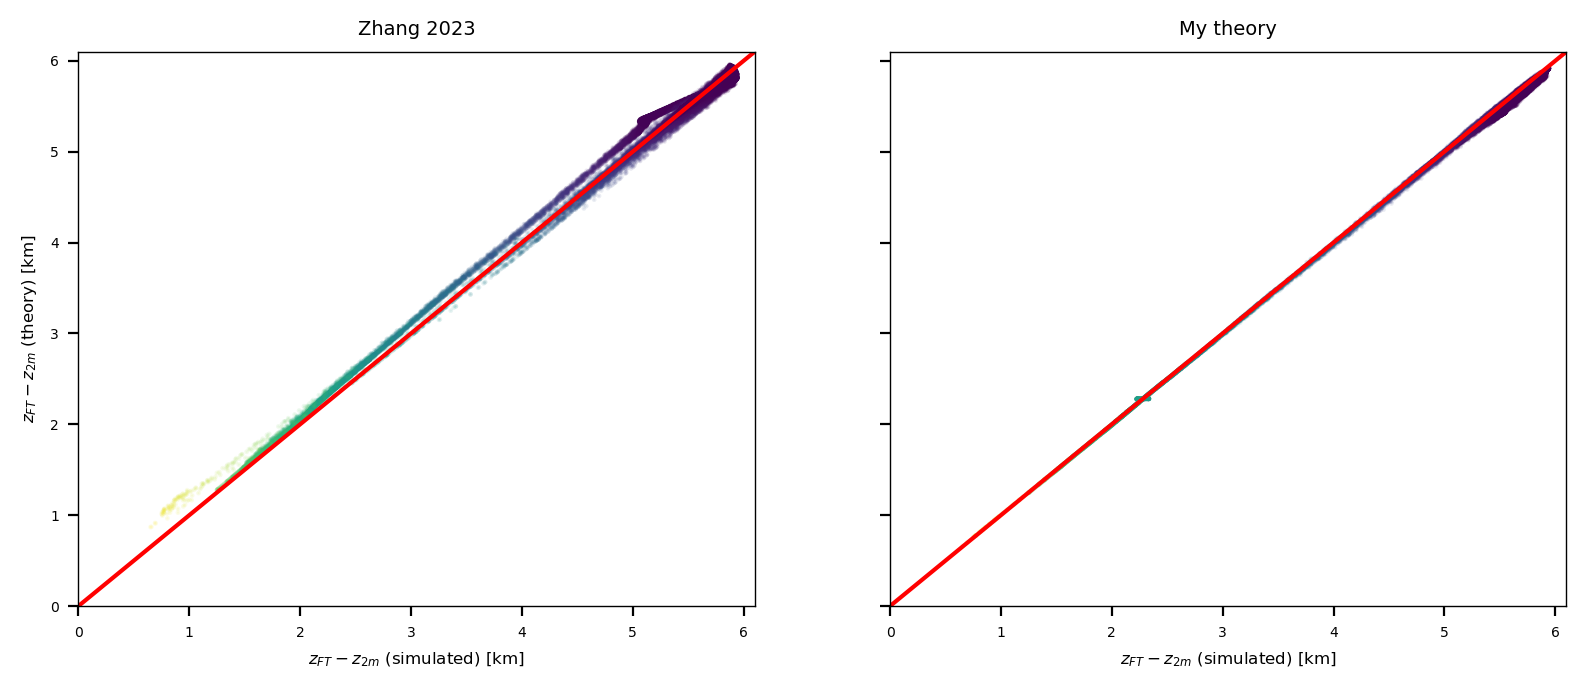

In [7]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
fig_resize(fig, 2*im_sz*width['one_col'])
ax[0].scatter(z_diff_plot['simulated']/1000, z_diff_plot['zhang']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax[1].scatter(z_diff_plot['simulated']/1000, z_diff_plot['theory']/1000,
              alpha=0.1, c=z2m/1000, cmap='viridis', s=0.5)
ax_lim = [0, 6.1]
for ax_use in ax:
    ax_use.set_xlabel('$z_{FT}-z_{2m}$ (simulated) [km]')
    ax_use.plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_ylabel('$z_{FT}-z_{2m}$ (theory) [km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
plt.show()

## Simulated change in 2m Temperature
Below we see arctic amplification to some degree over North America and Russia.

In [8]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.arange(40, 70, 25)):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

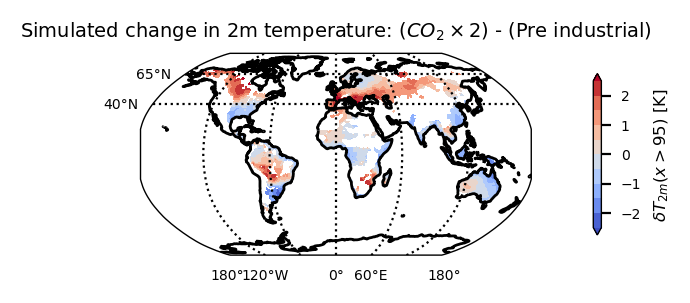

In [76]:
norm_by_ref = True
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=-90, lat_max=90)

var = ds[1].TREFHT - ds[0].TREFHT
if norm_by_ref:
    var -= temp_surf_ref_change
    var *= mask_ref

im = plot_contour_projection(var,
                             norm_temp_levels if norm_by_ref else np.arange(2, 12, 0.1),
                             cmap='coolwarm' if norm_by_ref else 'viridis', mask=None if norm_by_ref else land)
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}(x>95)$ [K]', mappable=im)
ax.set_title(f'Simulated change in 2m temperature: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
savefig(fig, format='png')

## Zhang 2023 Prediction
Below we see that the Zhang theory over estimates almost systematically the change in 2m temperature, and in the plot below this is clearly because specific humidity on these days increases everywhere.

In [11]:
def dT2m_dT500_theory(T500):
    # Prefactor to multiply by change in T_500 to get estimate of change in 2m temperature
    p500 = 500 * 100       # 500 hPa in Pa
    return 1 + L_v/c_p * clausius_clapeyron_factor(T500, p500) * sphum_sat(T500, p500)+z500_mean/t500_mean/c_p

t2m_change_zhang = dT2m_dT500_theory(ds[0].T) * (ds[1].T-ds[0].T)

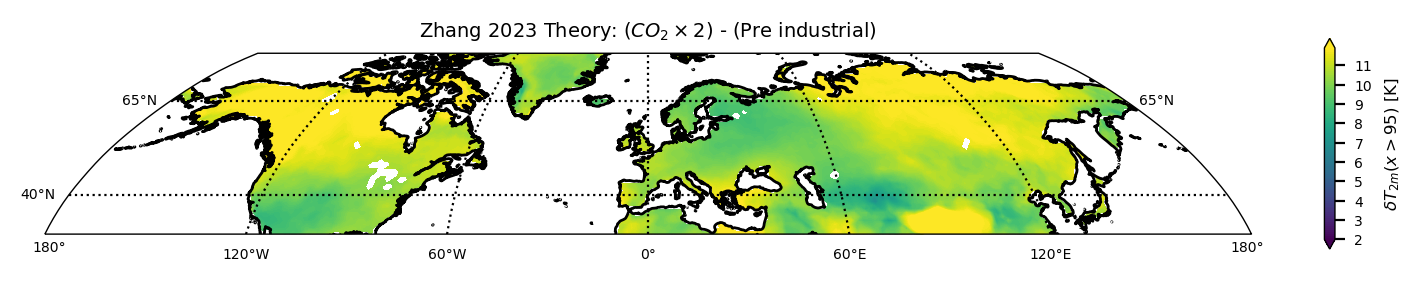

In [12]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)

im = plot_contour_projection(t2m_change_zhang, np.arange(2, 12, 0.1))
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}(x>95)$ [K]', mappable=im)
ax.set_title(f'Zhang 2023 Theory: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
# savefig(fig,format='png')

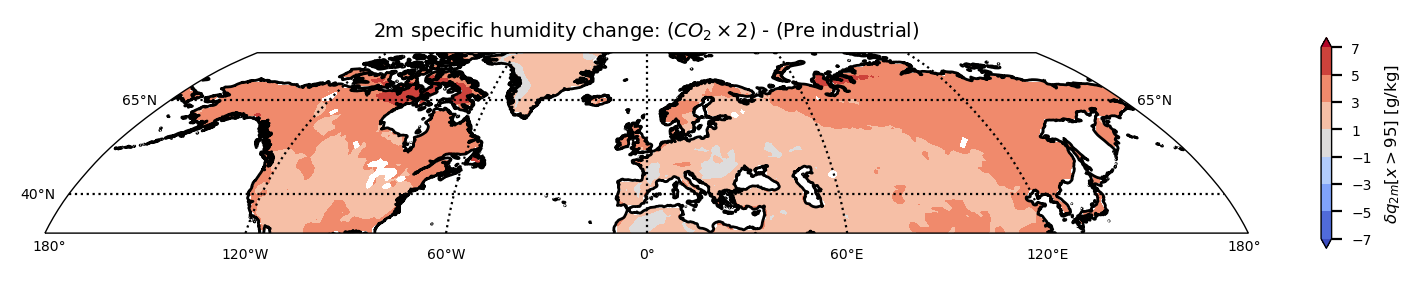

In [13]:
# Zhang theory neglects specific humidity change which is significant as shown below
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)

im = plot_contour_projection((ds[1].QREFHT - ds[0].QREFHT)*1000, np.linspace(-7, 7, 8), cmap='coolwarm')
fig.colorbar(shrink=0.8, ax=ax, label='$\delta q_{2m}[x>95]$ [g/kg]', mappable=im)
ax.set_title(f'2m specific humidity change: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
# savefig(fig,format='png')

## Compare Averaging methods
Below I compare the calculations of $\epsilon$ and relative humidity computed with averaged quantities, versus computed for each day and then averaged.

In [9]:
mse_refht = [moist_static_energy(ds[i].TREFHT, ds[i].QREFHT, z2m) for i in range(n_exp)]
mse_sat_ft = [moist_static_energy(ds[i].T, sphum_sat(ds[i].T, float(ds[i].plev)), ds[i].Z3) for i in range(n_exp)]
mse_lapse = [mse_refht[i] - mse_sat_ft[i] for i in range(n_exp)]
rh_refht = [ds[i].QREFHT / sphum_sat(ds[i].TREFHT, ds[i].PS) for i in range(n_exp)]

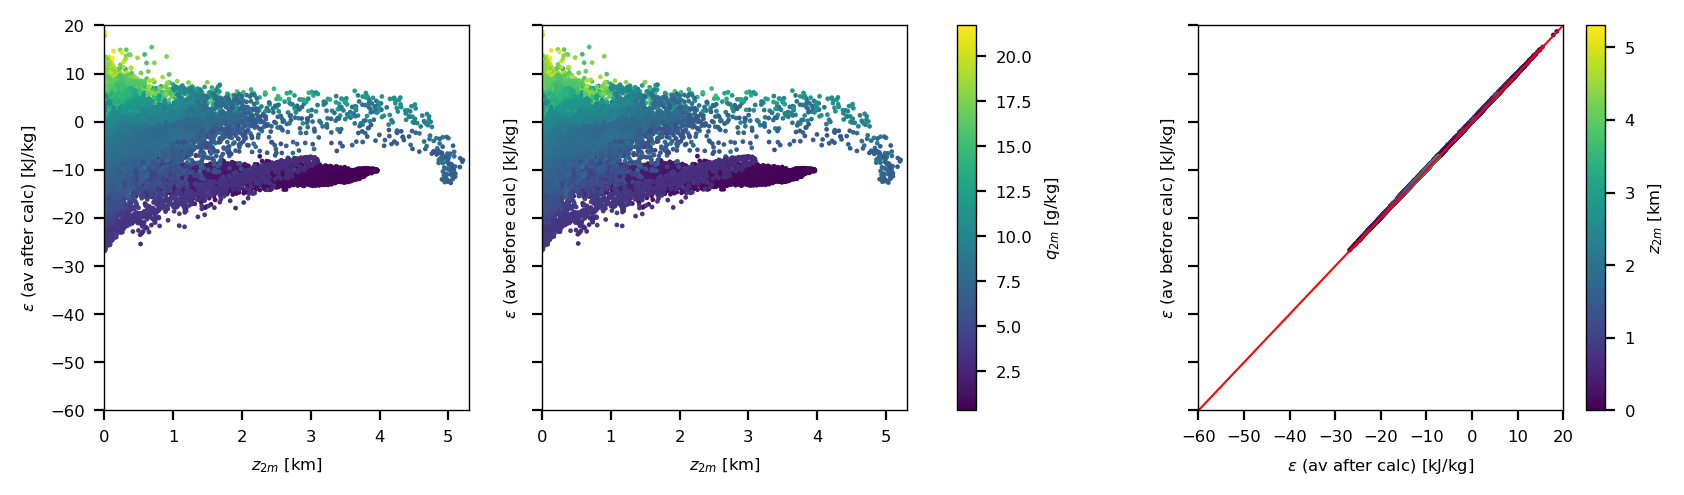

In [15]:
fig, ax = plt.subplots(1,3, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].scatter((z2m/1000)*land, ds[0].mse_lapse*land, s=0.5, c=ds[0].QREFHT*1000)
im = ax[1].scatter((z2m/1000)*land, mse_lapse[0]*land, s=0.5, c=ds[0].QREFHT*1000)
fig.colorbar(im, ax=ax[:2].ravel(), label='$q_{2m}$ [g/kg]')
for i in range(2):
    ax[i].set_xlim(0, 5.3)
    ax[i].set_xlabel('$z_{2m}$ [km]')
ax[0].set_ylabel('$\epsilon$ (av after calc) [kJ/kg]')
ax[1].set_ylabel('$\epsilon$ (av before calc) [kJ/kg]')

im = ax[2].scatter(ds[0].mse_lapse*land, mse_lapse[0]*land, c=(z2m/1000)*land, s=0.5, vmin=0, vmax=5.3)
ylim = [-60, 20]
ax[2].plot([ylim[0], ylim[1]],[ylim[0], ylim[1]], color='r', lw=1)
ax[2].set_xlim(ylim)
ax[2].set_ylim(ylim)
fig.colorbar(im, ax=ax[2:].ravel(), label='$z_{2m}$ [km]')
ax[2].set_xlabel('$\epsilon$ (av after calc) [kJ/kg]')
ax[2].set_ylabel('$\epsilon$ (av before calc) [kJ/kg]')
update_linewidth(fig)
update_fontsize(fig)
plt.show()

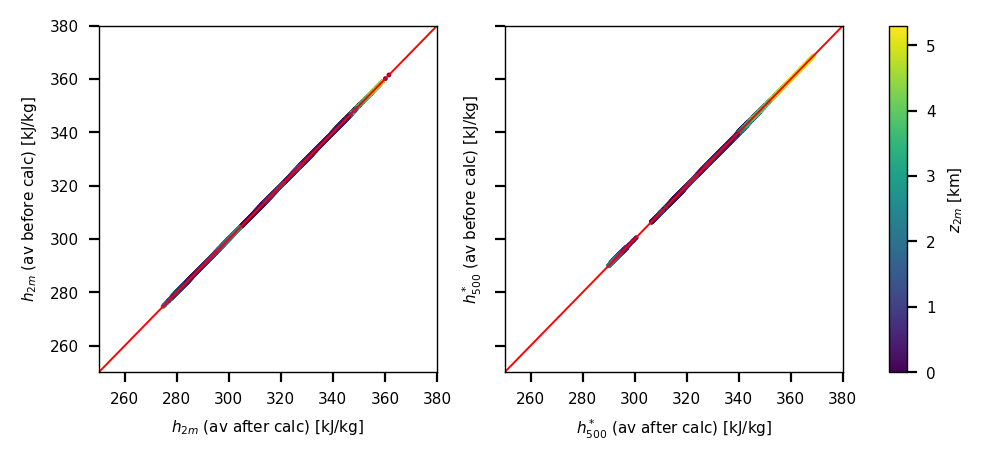

In [16]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
isca_tools.plot.fig_resize(fig, 6)

ax[0].scatter((ds[0].mse_refht)*land, (mse_refht[0])*land, c=(z2m/1000)*land, s=0.5, vmin=0, vmax=5.3)
im = ax[1].scatter((ds[0].mse_sat_ft)*land, (mse_sat_ft[0])*land, c=(z2m/1000)*land, s=0.5, vmin=0, vmax=5.3)
ylim = [250, 380]
ax[0].plot([ylim[0], ylim[1]],[ylim[0], ylim[1]], color='r', lw=0.5)
ax[1].plot([ylim[0], ylim[1]],[ylim[0], ylim[1]], color='r', lw=0.5)
ax[0].set_xlim(ylim)
ax[0].set_ylim(ylim)
fig.colorbar(im, ax=ax.ravel(), label='$z_{2m}$ [km]')
ax[0].set_xlabel('$h_{2m}$ (av after calc) [kJ/kg]')
ax[0].set_ylabel('$h_{2m}$ (av before calc) [kJ/kg]')
ax[1].set_xlabel('$h^*_{500}$ (av after calc) [kJ/kg]')
ax[1].set_ylabel('$h^*_{500}$ (av before calc) [kJ/kg]')
update_linewidth(fig)
update_fontsize(fig)
plt.show()

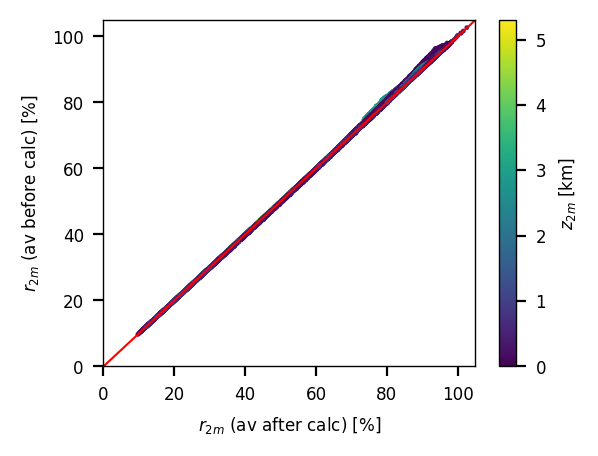

In [17]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 3)

im = ax.scatter((ds[0].rh_refht*100)*land, (rh_refht[0]*100)*land, c=(z2m/1000)*land, s=0.5, vmin=0, vmax=5.3)
ylim = [0, 105]
ax.plot([ylim[0], ylim[1]],[ylim[0], ylim[1]], color='r', lw=0.5)
ax.set_xlim(ylim)
ax.set_ylim(ylim)
fig.colorbar(im, ax=ax, label='$z_{2m}$ [km]')
ax.set_xlabel('$r_{2m}$ (av after calc) [%]')
ax.set_ylabel('$r_{2m}$ (av before calc) [%]')
update_linewidth(fig)
update_fontsize(fig)

In [10]:
def compute_grid_spacing_km(lat, lon):
    """
    Compute dy and dx (in km) from 1D lat and lon arrays using geodesic distances.

    Parameters:
        lat (np.ndarray): 1D array of latitude values
        lon (np.ndarray): 1D array of longitude values

    Returns:
        dy_km (np.ndarray): 1D array of spacing between latitudes (size: lat)
        dx_km (np.ndarray): 2D array of spacing between longitudes at each latitude (size: lat x lon)
    """
    # dy_km: spacing between latitudes at a fixed longitude (mid-lon)
    mid_lon = float(lon[len(lon) // 2])
    dy_km = np.array([
        geodesic((lat[i], mid_lon), (lat[i+1], mid_lon)).km
        for i in range(len(lat) - 1)
    ])
    dy_km = np.append(dy_km, dy_km[-1])  # pad to full length

    # dx_km: spacing between longitudes for each latitude
    dx_km = np.empty((len(lat), len(lon)))
    for i, phi in enumerate(lat):
        dx_row = np.array([
            geodesic((phi, lon[j]), (phi, lon[j+1])).km
            for j in range(len(lon) - 1)
        ])
        dx_row = np.append(dx_row, dx_row[-1])  # pad
        dx_km[i, :] = dx_row

    return dy_km, dx_km

def compute_distance_to_ocean(land_mask: xr.DataArray) -> xr.DataArray:
    """
    Compute approximate distance (in km) from each land point to the nearest ocean
    using distance transform and real Earth spacing between lat/lon grid points.

    Parameters:
    -----------
    land_mask : xr.DataArray
        2D array with dimensions ('lat', 'lon'), where 1 = land, 0 = ocean

    Returns:
    --------
    xr.DataArray
        2D array of distances to ocean (in km), same shape as land_mask
    """
    # Ensure lat is ascending
    if land_mask['lat'][0] > land_mask['lat'][-1]:
        land_mask = land_mask.sortby('lat')

    lat = land_mask['lat'].values
    lon = land_mask['lon'].values

    # Compute dy and dx spacing in km
    dy_km, dx_km = compute_grid_spacing_km(lat, lon)

    # Apply distance transform with dy as sampling
    mean_dy = np.mean(dy_km)
    edt = distance_transform_edt(land_mask.values, sampling=(mean_dy, 1))
    distance_km = edt * dx_km  # scale horizontal spacing per latitude

    # Set ocean distance to 0 (optional)
    distance_km[land_mask.values == 0] = 0

    return xr.DataArray(
        distance_km,
        coords=land_mask.coords,
        dims=land_mask.dims,
        name="distance_to_ocean_km",
        attrs={"units": "km", "description": "Approximate distance to nearest ocean point"}
    )
# dist_to_ocean = compute_distance_to_ocean(land)

### Change mechanisms
Below I look at ideas for further constraining how $r_{2m}$, $T_{500}$ and $\epsilon$ may change with warming. In each case, I colour by $\epsilon$ in the base climate, to emphasize the pixels where the theory should be applied.

#### Relative Humidity
This seems to be within an upper bound of $\delta r < 0$ and a lower bound of $\delta r > -r/2$

#### 500hPa Temperature
This seems to be larger for smaller starting $T_{500}$. The outliers to the right, have large $z_{2m}$.

#### CAPE proxy or $\epsilon$
The change in $\epsilon$ seems to be highly correlated with the change in 2m specific humidity. This may be related to entrainment theories, where we expect a decrease in column relative humidity to cause an increase in CAPE.

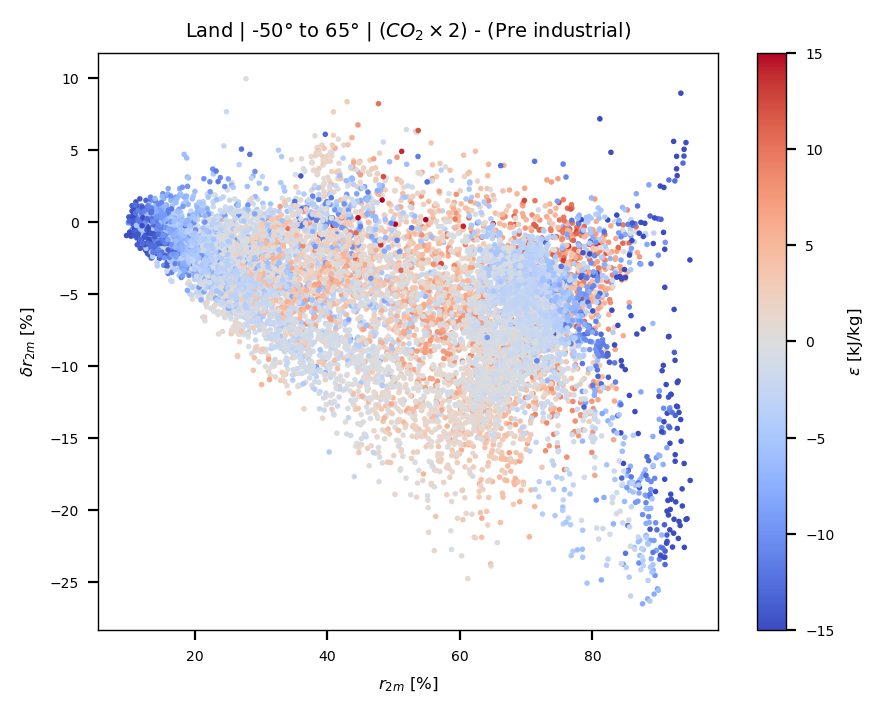

In [207]:
lat_min = -50
lat_max = 65

fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
ds_use = [ds[i].sel(lat=slice(lat_min, lat_max)) * land for i in range(n_exp)]
im = ax.scatter(ds_use[0].rh_refht*100, (ds_use[1].rh_refht - ds_use[0].rh_refht)*100, s=1,
                c=ds_use[0].mse_lapse*land, vmin=-15, vmax=15, cmap='coolwarm')
fig.colorbar(im, ax=ax, label='$\epsilon$ [kJ/kg]')
ax.set_xlabel('$r_{2m}$ [%]')
ax.set_ylabel('$\delta r_{2m}$ [%]')
ax.set_title(f'Land | {lat_min}$\degree$ to {lat_max}$\degree$ | ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

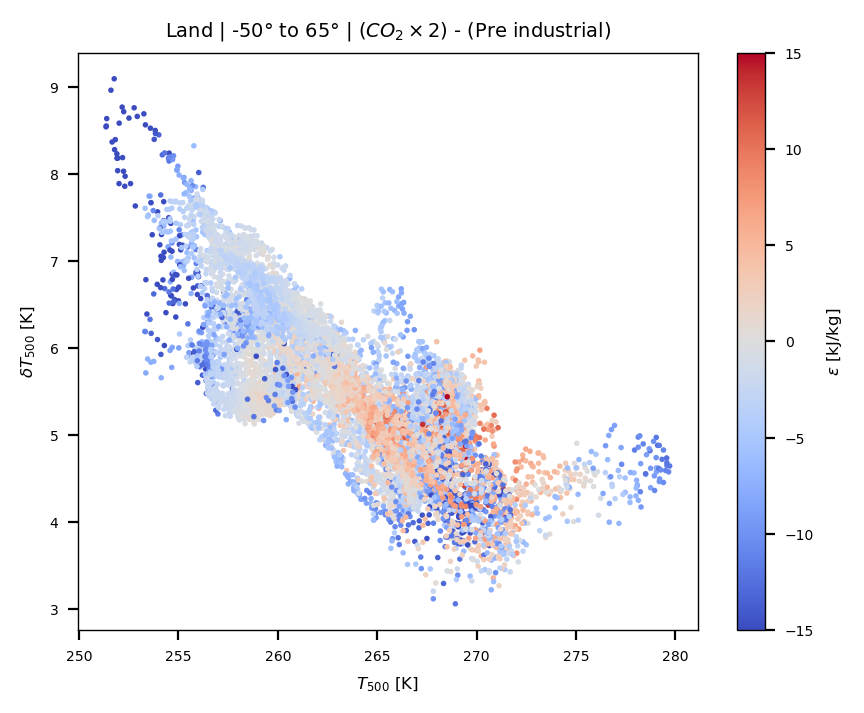

In [20]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter(ds_use[0].T, ds_use[1].T - ds_use[0].T, s=1,
                c=ds_use[0].mse_lapse*land, vmin=-15, vmax=15, cmap='coolwarm')
fig.colorbar(im, ax=ax, label='$\epsilon$ [kJ/kg]')
ax.set_xlabel('$T_{500}$ [K]')
ax.set_ylabel('$\delta T_{500}$ [K]')
ax.set_title(f'Land | {lat_min}$\degree$ to {lat_max}$\degree$ | ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

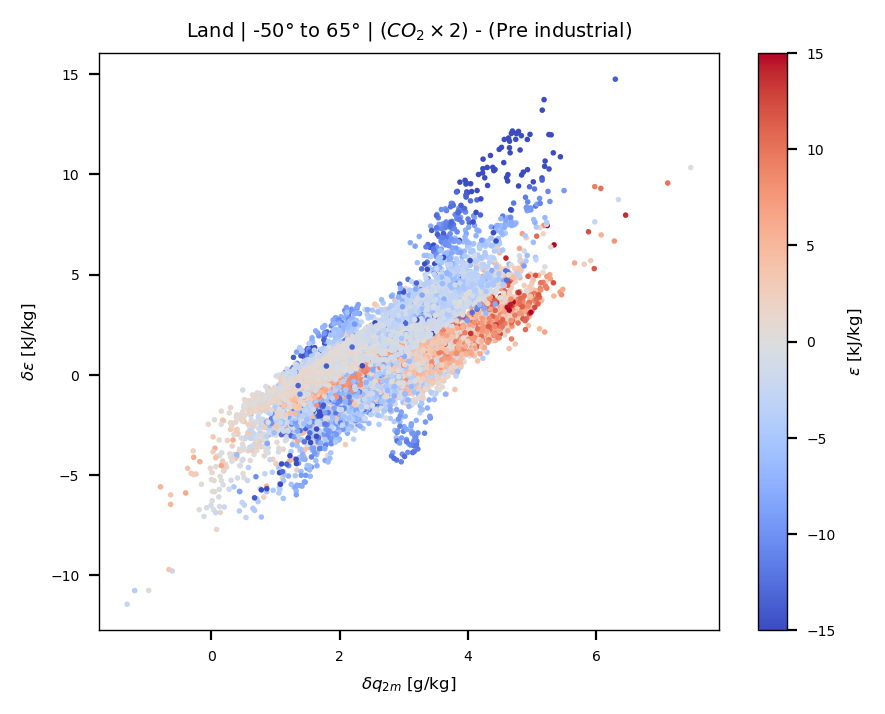

In [21]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter((ds_use[1].QREFHT-ds_use[0].QREFHT)*1000, ds_use[1].mse_lapse - ds_use[0].mse_lapse, s=1,
                c=ds_use[0].mse_lapse*land, vmin=-15, vmax=15, cmap='coolwarm')
fig.colorbar(im, ax=ax, label='$\epsilon$ [kJ/kg]')
ax.set_xlabel('$\delta q_{2m}$ [g/kg]')
ax.set_ylabel('$\delta \epsilon$ [kJ/kg]')
ax.set_title(f'Land | {lat_min}$\degree$ to {lat_max}$\degree$ | ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

## My Theory
My theory captures the simulated change better.

In [12]:
def get_exp_quant_array(ds_list, var, lat_ind):
    # Returns an n_exp x n_lon array of given variable where ds_list contains n_exp datasets
    var_ind = {'lat': lat_ind}
    dims = ds_list[0][var].dims & var_ind.keys()        # only consider dimensions in both variable and var_ind
    return np.asarray([ds_list[i][var].isel({key: var_ind[key] for key in dims}).to_numpy() for i in range(len(ds_list))])

In [15]:
n_lat = ds[0].lat.size
n_lon = ds[0].lon.size
scape = np.zeros((n_exp, n_lat, n_lon))
pbar = tqdm(total=n_exp*n_lat)
for i in range(n_exp):
    for j in range(n_lat):
        ds_use = ds[i].isel(lat=j)
        scape[i, j] = get_cape_approx(ds_use.TREFHT.to_numpy(), ds_use.rh_refht.to_numpy(), ds_use.PS.to_numpy(), float(ds_use.plev),
                                      ds_use.T, ds_use.mse_lapse)[0]
        pbar.update(1)
    ds[i]["scape"] = xr.DataArray(
        data=scape[i],
        dims=ds[i]["mse_lapse"].dims,
        coords=ds[i]["mse_lapse"].coords,
        name="scape"
    )
pbar.close()

  0%|          | 0/384 [00:00<?, ?it/s]

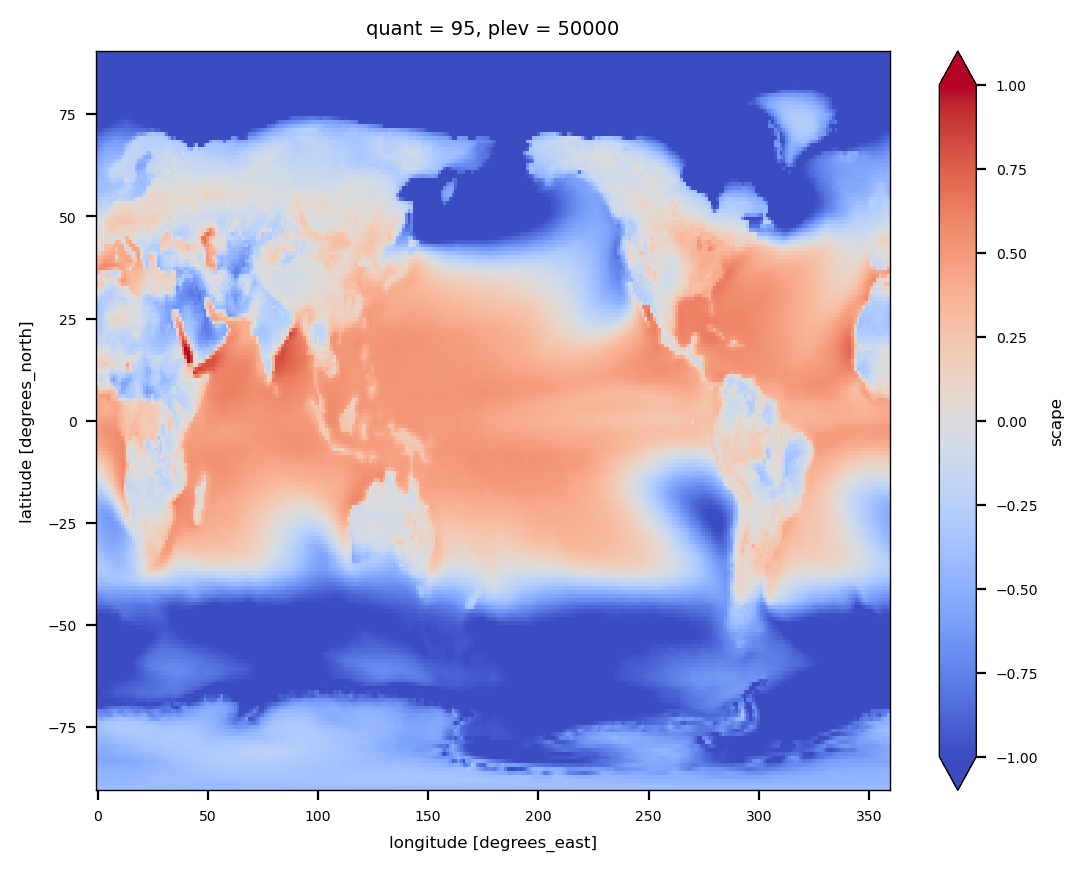

In [16]:
ds[0].scape.plot(vmin=-1, vmax=1, cmap='coolwarm')

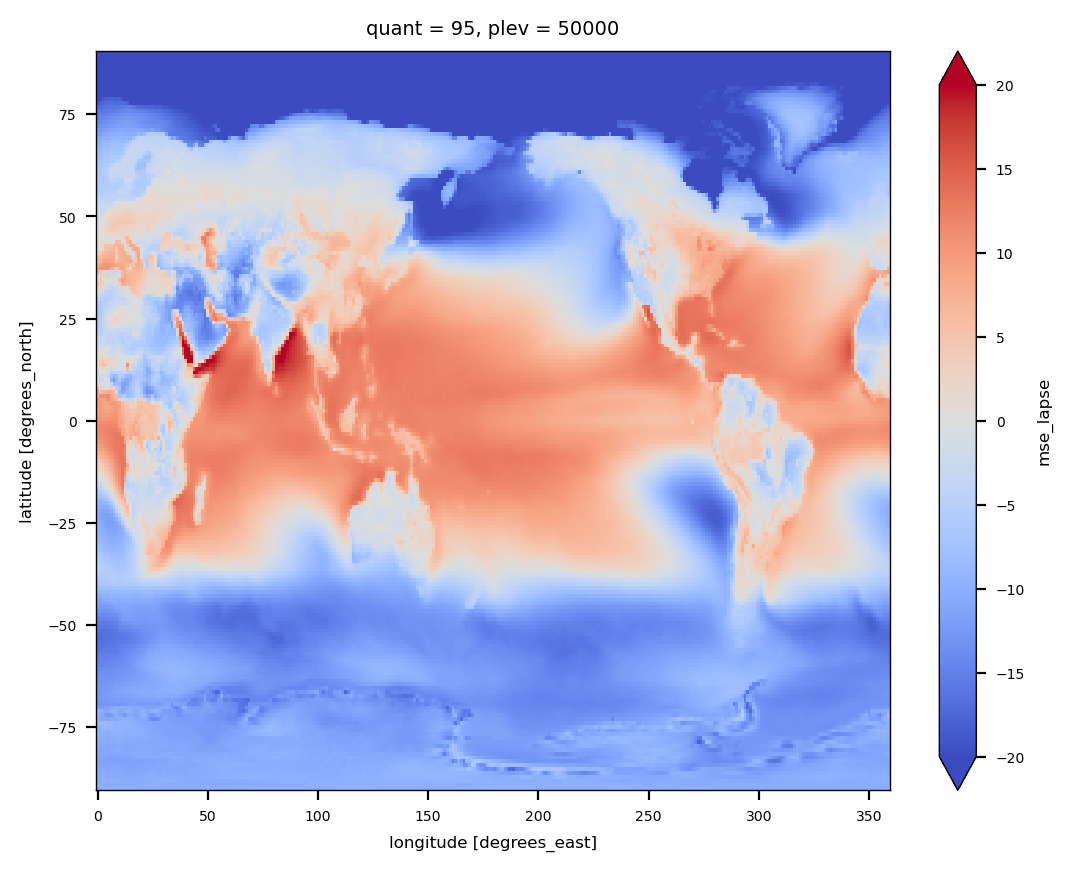

In [19]:
ds[0].mse_lapse.plot(vmin=-20, cmap='coolwarm')

In [37]:
# Set reference dataset to be average chosen land region
lat_min_ref = -90
lat_max_ref = 90
mask_ref = copy.deepcopy(land)
mask_ref = mask_ref * (ds[0].mse_lapse>-4) * (np.abs(ds[1].mse_lapse-ds[0].mse_lapse)<4)
mask_ref = mask_ref * (z2m < 1000)      # only consider regions less than 1KM in height
mask_ref = mask_ref.where(mask_ref>0)   # where 0 set to nan
ds_av = [isca_tools.utils.area_weighting(ds[i].sel(lat=slice(lat_min_ref, lat_max_ref))[['TREFHT', 'rh_refht', 'PS', 'T']] * mask_ref).mean(dim=['lat', 'lon'])
          for i in range(n_exp)]
ds_ref = [copy.deepcopy(ds_av[i]) for i in range(n_exp)]
ds_ref[1]['rh_refht'] = ds_ref[0]['rh_refht']    # set ref RH to be the same in all cases
temp_surf_ref_change = float(ds_ref[1].TREFHT - ds_ref[0].TREFHT)
# # Compute FT temperature of reference day if following exact adiabat
j=0
ds_ref[0]['T'], ds_ref[1]['T'] = get_temp_adiabat(get_exp_quant_array(ds_ref, 'TREFHT', j), get_exp_quant_array(ds_ref, 'rh_refht', j) *
                                       sphum_sat(get_exp_quant_array(ds_ref, 'TREFHT', j), float(ds_ref[0].PS)),
                                       float(ds_ref[0].PS), float(ds_ref[0].plev))

In [38]:
sf_theory = np.zeros((n_lat, n_lon))
sf_theory_breakdown = {key: np.zeros((n_lat, n_lon)) for key in
                       ['temp_ft_change', 'r_change', 'temp_anom', 'r_anom', 'cape_change']}

for j in tqdm(range(n_lat)):
    sf_theory[j], info_coef, _, info_cont = \
        get_scale_factor_theory(get_exp_quant_array(ds_ref, 'TREFHT', j), get_exp_quant_array(ds, 'TREFHT', j),
                                get_exp_quant_array(ds_ref, 'rh_refht', j), get_exp_quant_array(ds, 'rh_refht', j),
                                get_exp_quant_array(ds, 'T', j), get_exp_quant_array(ds, 'mse_lapse', j),
                                float(ds_ref[0].PS), float(ds_ref[0].plev), cape_form=True,
                                pressure_surf_quant=get_exp_quant_array(ds, 'PS', j))
    for key2 in sf_theory_breakdown:
        sf_theory_breakdown[key2][j] = info_cont[key2]

# Compute theoretical estimate of the ref temp change, as is not exactly equal to actual value
j = 0
# Compute scaling factor of the ref temp change, assuming exact adiabat. Should be 1, but is not due to approximations
sf_theory_ref, _, _, info_cont = get_scale_factor_theory(get_exp_quant_array(ds_ref, 'TREFHT', j),
                                                         get_exp_quant_array(ds_ref, 'TREFHT', j)[:, np.newaxis],
                                                         get_exp_quant_array(ds_ref, 'rh_refht', j),
                                                         get_exp_quant_array(ds_ref, 'rh_refht', j)[:, np.newaxis],
                                                         get_exp_quant_array(ds_ref, 'T', j)[:, np.newaxis], np.zeros((2, 1)), float(ds_ref[0].PS),
                                                         float(ds_ref[0].plev), cape_form=True)
temp_surf_ref_change_theory = float(temp_surf_ref_change * sf_theory_ref)
sf_theory = sf_theory - sf_theory_ref + 1       # modify sf_theory to account for theory estimated ref change wrong
sf_theory = ds[0].TREFHT.copy(data=sf_theory)   # convert to xarray
temp_surf_change_theory = sf_theory * temp_surf_ref_change
sf_theory_breakdown['temp_ft_change'] -= info_cont['temp_ft_change']    # normalise relative to reference value - only ft_change term in ref theoretical sf
print(np.abs(sf_theory-1 - sum([sf_theory_breakdown[key] for key in sf_theory_breakdown])).max())   # sanity check that sum of terms equals scaling factor

# convert breakdown into xarray
for key in sf_theory_breakdown:
    sf_theory_breakdown[key] = ds[0].TREFHT.copy(data=sf_theory_breakdown[key])     # convert to xarray

  0%|          | 0/192 [00:00<?, ?it/s]

<xarray.DataArray 'TREFHT' ()> Size: 8B
array(3.56603636e-13)
Coordinates:
    quant    int64 8B 95
    plev     int64 8B 50000


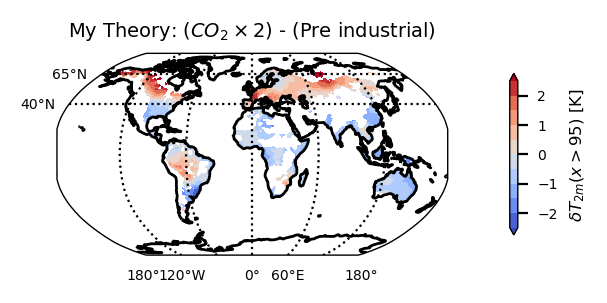

In [75]:
norm_by_ref = True
norm_temp_levels = np.linspace(-2.5, 2.5, 11)
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=-90, lat_max=90)
im = plot_contour_projection(temp_surf_change_theory-int(norm_by_ref)*temp_surf_ref_change,
                             norm_temp_levels if norm_by_ref else np.arange(2, 12, 0.1),
                             cmap='coolwarm' if norm_by_ref else 'viridis', mask=mask_ref)
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}(x>95)$ [K]', mappable=im)
ax.set_title(f'My Theory: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
savefig(fig, format='png')

### Mechanism breakdown
Below, we look at the contribution from each individual mechanism to the temperature change in my theory.

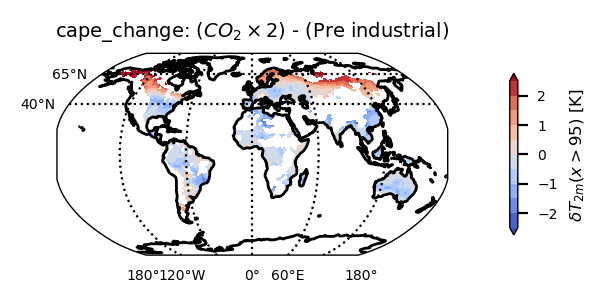

In [82]:
norm_change = True # subtract by average of that term, so rather than all terms with rh_change<0 show as red, all with rh_change<rh_change_av show as red
key = 'cape_change'
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=-90, lat_max=90)
var = sf_theory_breakdown[key]*temp_surf_ref_change
if norm_change and 'change' in key:
    var = var - (var*mask_ref).sel(lat=slice(lat_min_ref, lat_max_ref)).mean()
im = plot_contour_projection(var, norm_temp_levels, cmap='coolwarm', mask=mask_ref)
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{2m}(x>95)$ [K]', mappable=im)
ax.set_title(f'{key}: ({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()
savefig(fig, format='png')

\## CAPE in pre-industrial simulation
Below, we see what daily mean CAPE looks like in the pre-industrial simulation averaged over 5% hottest days.

There is a significant difference depending on whether $\epsilon$ is computed on each individual day, and then averaged (first plot) or computed using then average temperature and humidity quantities.

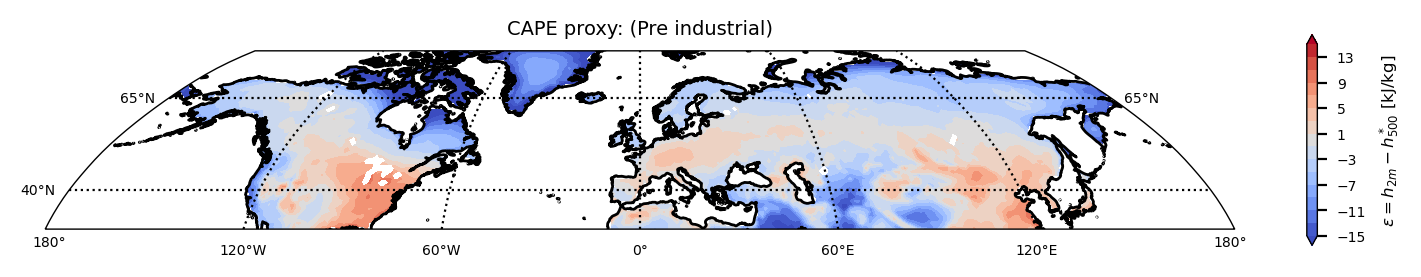

In [27]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)

im = plot_contour_projection(ds[0].mse_lapse, levels=np.arange(-15, 17, 2), cmap='coolwarm')
fig.colorbar(shrink=0.8, ax=ax, label='$\epsilon = h_{2m} - h_{500}^*$ [kJ/kg]', mappable=im)
ax.set_title(f'CAPE proxy: ({exp_labels[0]})')
plt.show()

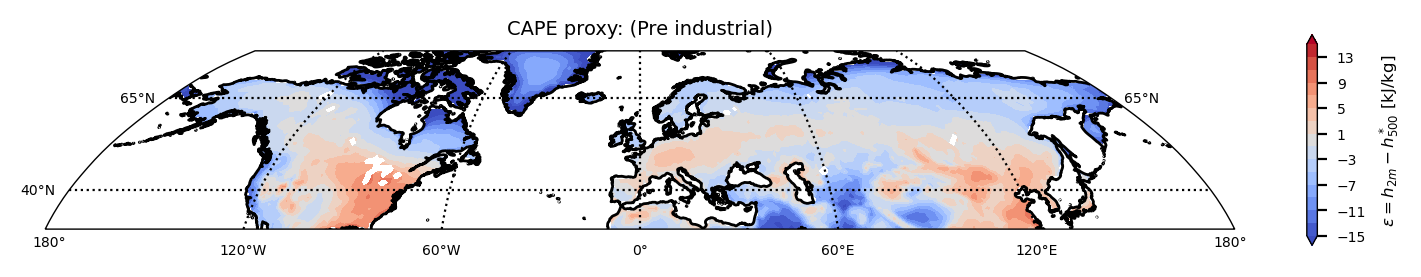

In [28]:
fig = plt.figure(constrained_layout=True,figsize=(7.,1.4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax)

im = plot_contour_projection(mse_lapse[0], levels=np.arange(-15, 17, 2), cmap='coolwarm')
fig.colorbar(shrink=0.8, ax=ax, label='$\epsilon = h_{2m} - h_{500}^*$ [kJ/kg]', mappable=im)
ax.set_title(f'CAPE proxy: ({exp_labels[0]})')
plt.show()

## Sanity check on lapse rate change with warming
Below, I calculate the LCL. I then compute the lapse rate above the LCL to see how it compares to the expected moist adiabatic lapse rate response.

In [189]:


def get_lcl_metpy(t_2m, q_2m, pressure_surf, z_2m):
    # Extract and convert to units
    q = q_2m.values * metpy.units.units('kg/kg')
    T = t_2m.values * metpy.units.units.kelvin
    P = pressure_surf.values  * metpy.units.units.pascal

    # Calculate dewpoint from mixing ratio
    dewpoint = metpy.calc.dewpoint_from_specific_humidity(P, q)
    lcl_pressure, lcl_temperature = metpy.calc.lcl(P, T, dewpoint)
    dims = t_2m.dims
    coords = t_2m.coords

    # Convert MetPy Quantities to numpy arrays and units to attributes
    lcl_pressure_xr = xr.DataArray(
        data=lcl_pressure.magnitude,
        dims=dims,
        coords=coords,
        name='lcl_pressure',
        attrs={'units': str(lcl_pressure.units), 'long_name': 'LCL pressure'}
    )

    lcl_temperature_xr = xr.DataArray(
        data=lcl_temperature.magnitude,
        dims=dims,
        coords=coords,
        name='lcl_temperature',
        attrs={'units': str(lcl_temperature.units), 'long_name': 'LCL temperature'}
    )

    lapse_dry = g/c_p
    z_lcl = z_2m + (t_2m - lcl_temperature_xr) / lapse_dry
    return lcl_pressure_xr, lcl_temperature_xr, z_lcl

In [190]:
for i in range(n_exp):
    ds[i]['p_lcl'], ds[i]['t_lcl'], ds[i]['z_lcl'] = get_lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PS, z2m)
    ds[i]['lapse_below_lcl'] = (ds[i]['t_lcl'] - ds[i].TREFHT) / (z2m - ds[i]['z_lcl']) * 1000      # sanity check, should be g/c_p
    ds[i]['lapse_above_lcl'] = (ds[i].T - ds[i].t_lcl) / (ds[i].z_lcl - ds[i].Z3) * 1000

In [255]:
def solve_adiabat_xarray(temp_surf_da, sphum_surf_da, ps_da, p_ft):
    """
    Vectorized solve over xarray DataArrays for given free-troposphere pressure level (p_ft)
    """
    return xr.apply_ufunc(
        get_temp_adiabat,
        temp_surf_da,
        sphum_surf_da,
        ps_da,
        input_core_dims=[[], [], []],
        kwargs={'pressure_ft': p_ft},
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
for i in range(n_exp):
    ds[i]['T_adiabat'] = solve_adiabat_xarray(ds[i]['TREFHT'], ds[i]['QREFHT'], ds[i]['PS'], 500*100)
    ds[i]['Z3_adiabat'] = get_z_theory(ds[i]['TREFHT'], ds[i].T_adiabat, ds[i].PS, 500*100) + z2m
    ds[i]['lapse_above_lcl_adiabat'] = (ds[i].T_adiabat - ds[i].t_lcl) / (ds[i].z_lcl - ds[i].Z3_adiabat) * 1000

### Dry Adiabat - Below LCL
Sanity check that LCL height increases as RH deceases, and that a decrease in RH leads to increase in LCL height.

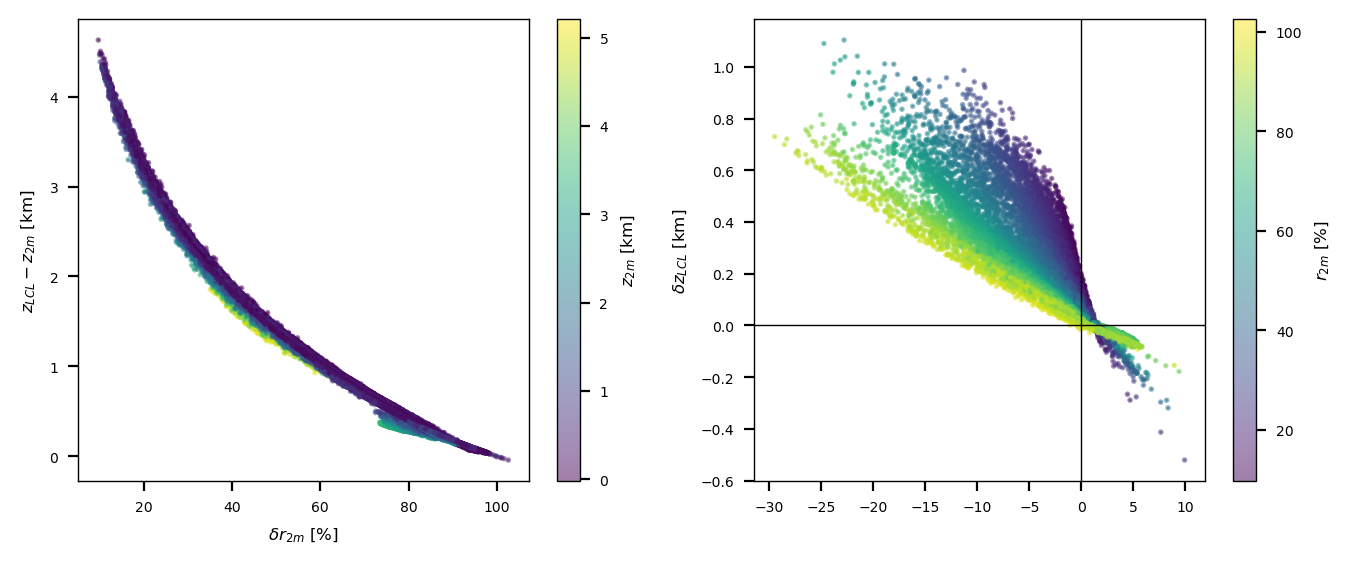

In [425]:
fig, ax = plt.subplots(1, 2)
isca_tools.plot.fig_resize(fig, 8)
im = ax[0].scatter(ds[0].rh_refht*100 * land, (ds[0].z_lcl-z2m)/1000 * land, s=1, alpha=0.5, c=z2m/1000)
plt.colorbar(im, ax=ax[0], label='$z_{2m}$ [km]')
im = ax[1].scatter((ds[1].rh_refht-ds[0].rh_refht)*100 * land, (ds[1].z_lcl-ds[0].z_lcl)/1000 * land, s=1, alpha=0.5, c=ds[0].rh_refht*100)
plt.colorbar(im, ax=ax[1], label='$r_{2m}$ [%]')
ax[0].set_xlabel('$r_{2m}$ [%]')
ax[0].set_xlabel('$\delta r_{2m}$ [%]')
ax[0].set_ylabel('$z_{LCL} - z_{2m}$ [km]')
ax[1].set_ylabel('$\delta z_{LCL}$ [km]')
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axvline(0, color='k', lw=0.5)

### Moist Adiabat - Above LCL
In a given climate, it is expected that the moist adiabatic lapse rate increases as $T_{500}$ decreases, as on the left. But the lapse rate above the LCL does not do this, as shown on the right.

In the plot below, we see that the actual lapse rate is greater than the moist adiabatic lapse rate wherever $\epsilon > 0$ i.e. positive CAPE means lapse rate closer to dry adiabatic.

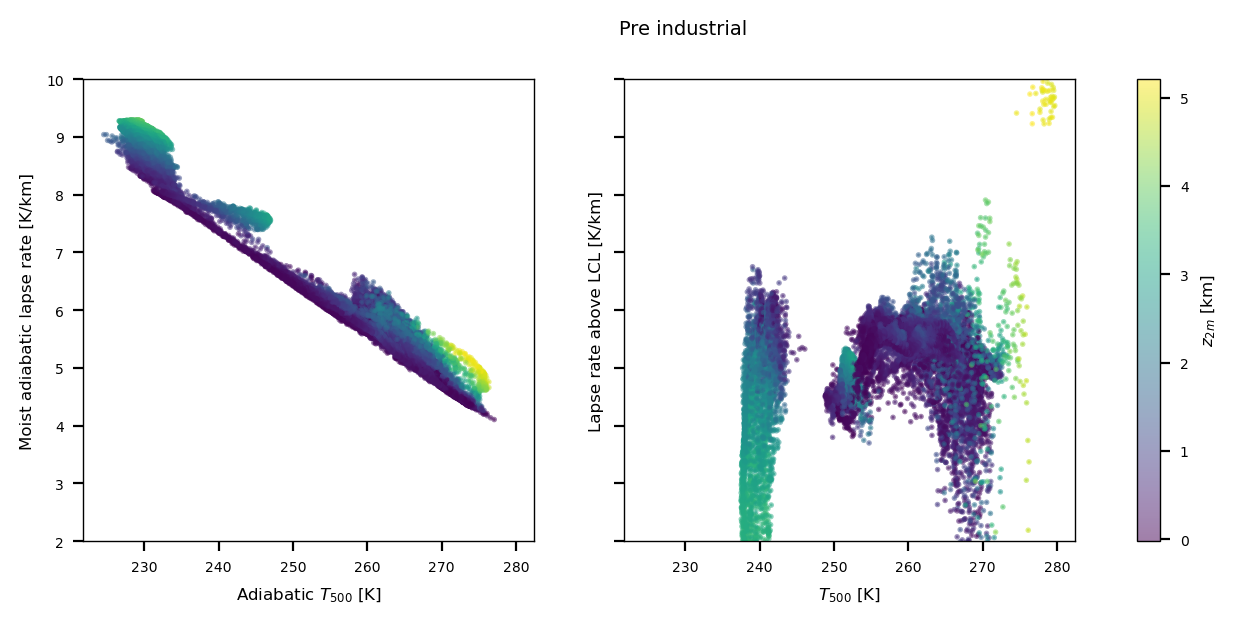

In [428]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 8)
ax[0].scatter(ds[0].T_adiabat*land, ds[0].lapse_above_lcl_adiabat*land, c=z2m/1000, s=1, alpha=0.5)
im = ax[1].scatter(ds[0].T*land, ds[0].lapse_above_lcl*land, c=z2m/1000, s=1, alpha=0.5)
plt.colorbar(im, ax=ax[:], label='$z_{2m}$ [km]')
ax[0].set_ylim(2, 10)
ax[0].set_xlabel('Adiabatic $T_{500}$ [K]')
ax[1].set_xlabel('$T_{500}$ [K]')
ax[0].set_ylabel('Moist adiabatic lapse rate [K/km]')
ax[1].set_ylabel('Lapse rate above LCL [K/km]')
fig.suptitle(exp_labels[0])
plt.show()

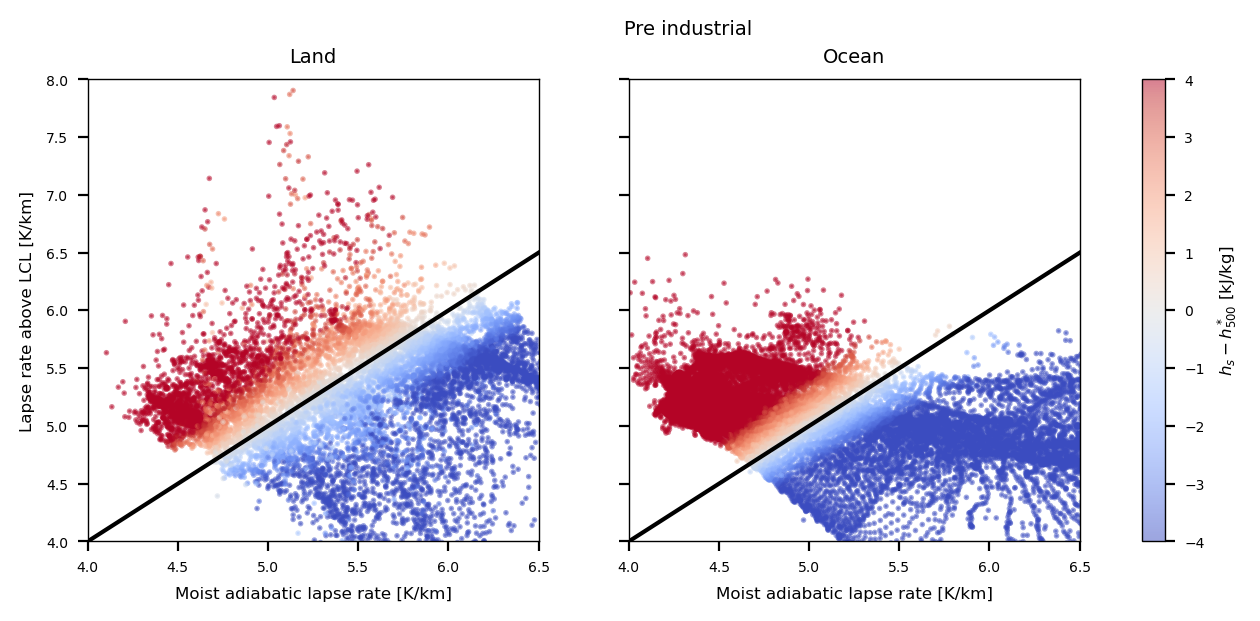

In [375]:
i=0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 8)
ax[0].scatter(ds[i].lapse_above_lcl_adiabat * land, ds[i].lapse_above_lcl * land,
              s=1, alpha=0.5, c=ds[i].mse_lapse, vmin=-4, vmax=4, cmap='coolwarm')
im = ax[1].scatter(ds[i].lapse_above_lcl_adiabat * ocean, ds[i].lapse_above_lcl * ocean,
              s=1, alpha=0.5, c=ds[i].mse_lapse, vmin=-4, vmax=4, cmap='coolwarm')
ax[0].set_xlim(4, 6.5)
ax[0].set_ylim(4, 8)
fig.suptitle(exp_labels[i])
for i in range(n_exp):
    ax[i].plot([4, 6.5], [4, 6.5], color='k')
    ax[i].set_xlabel('Moist adiabatic lapse rate [K/km]')
plt.colorbar(im, ax=ax[:], label='$h_s-h_{500}^*$ [kJ/kg]')
ax[0].set_ylabel('Lapse rate above LCL [K/km]')
ax[0].set_title('Land')
ax[1].set_title('Ocean')
plt.show()

#### Change with warming
Below in black, we see that it is expected that a larger change in free tropospheric temperature will lead to a larger decrease in lapse rate. However, this is not the case for the simulated lapse rate, especially over land.

In general, an increase in the CAPE proxy, $\epsilon$, reduces the expected lapse rate decrease. And in general, the larger $\delta T_{500}$, the larger $\delta \epsilon$.

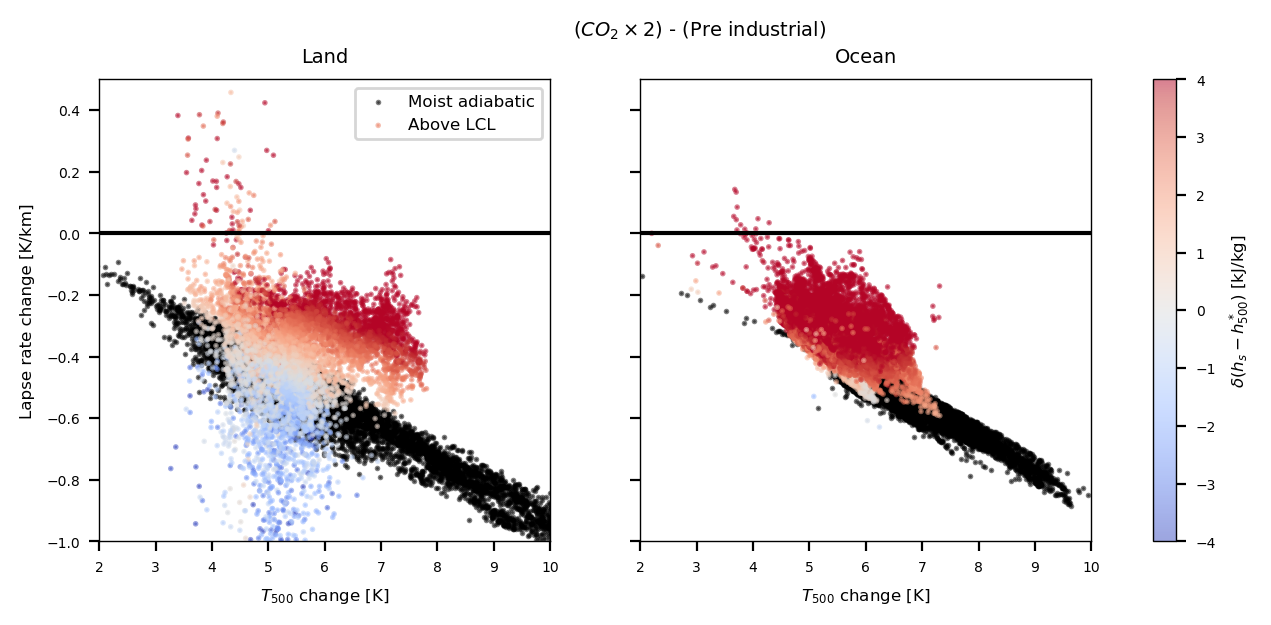

In [407]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 8)
for i, mask in enumerate([land * ds[0].mse_lapse > -4, ocean * ds[0].mse_lapse > -4]):
    ax[i].scatter((ds[1].T_adiabat-ds[0].T_adiabat) * mask, (ds[1].lapse_above_lcl_adiabat - ds[0].lapse_above_lcl_adiabat) * mask,
                  s=1, alpha=0.5, label='Moist adiabatic', color='k')
    im = ax[i].scatter((ds[1].T-ds[0].T) * mask, (ds[1].lapse_above_lcl - ds[0].lapse_above_lcl) * mask,
                  s=1, alpha=0.5, c=ds[1].mse_lapse-ds[0].mse_lapse, vmin=-4, vmax=4, cmap='coolwarm', label='Above LCL')
    ax[i].axhline(0, color='k')
    ax[i].set_xlabel('$T_{500}$ change [K]')
    ax[i].set_title('Land' if i==0 else 'Ocean')
ax[0].set_ylim(-1, 0.5)
ax[0].set_xlim(2, 10)
ax[0].legend()
ax[0].set_ylabel('Lapse rate change [K/km]')
plt.colorbar(im, ax=ax[:], label='$\delta (h_s-h_{500}^*)$ [kJ/kg]')
fig.suptitle(f"({exp_labels[1]}) - ({exp_labels[0]})")
# im = ax[1].scatter(ds[i].lapse_above_lcl_adiabat * ocean, ds[i].lapse_above_lcl * ocean,
#               s=1, alpha=0.5, c=ds[i].mse_lapse, vmin=-4, vmax=4, cmap='coolwarm')
# ax[0].set_xlim(4, 6.5)
# ax[0].set_ylim(4, 8)
# fig.suptitle(exp_labels[i])
# for i in range(n_exp):
#     ax[i].plot([4, 6.5], [4, 6.5], color='k')
#     ax[i].set_xlabel('Moist adiabatic lapse rate [K/km]')
# plt.colorbar(im, ax=ax[:], label='$h_s-h_{500}^*$ [kJ/kg]')
# ax[0].set_ylabel('Lapse rate above LCL [K/km]')
# ax[0].set_title('Land')
# ax[1].set_title('Ocean')
plt.show()